# Dependency Parsing with Eisner
Par Louis GERARD & Tiago CORTINHAL

In [98]:
import sys
venv_root = '/var/lib/vz/data/g13005245/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

## Features 1

We start building a model on these features :
- Governor POS
- Dependant POS
- Distance between these words

### Read data

We read the conllu file to get aall the info we need. In order to make this reusable, we can add any feature to the final list by adding its index to `features_enabled`. Here we have :
- the index, to identify our token
- the part of speech, which we want to pass to our model
- the governor index, to build pairs

In [104]:
sentences = []

conllu_filename = "UD_French-GSD/fr_gsd-ud-train.conllu"
features = ['INDEX', 'FORM', 'LEMMA', 'POS', 'X1', 'MORPHO', 'GOV', 'LABEL', 'X2', 'X3']
features_enabled = [0, 3, 6]
root = [0, 'ROOT', 'ROOT', 0]

columns = []
for i, f in enumerate(features):
    if i in features_enabled:
        columns.append(f)
        
with open(conllu_filename, 'r', encoding='utf-8') as conllu_file:
    sentence = []
    for i in range(len(features_enabled)):
        sentence.append([root[i]])
    tokens = []
    for line in conllu_file:
        if line[0] == '\n':
            if len(sentence) > 1:
                sentences.append(sentence)
                sentence = []
                for i in range(len(features_enabled)):
                    sentence.append([root[i]])
        elif line[0] == '#':
            pass
        else:
            tokens = line.split('\t')
            if '-' not in tokens[0]:
                for i, j in enumerate(features_enabled):
                    sentence[i].append(tokens[j])

pd.DataFrame(sentences[1]).T

,0,1,2
0,0,ROOT,ROOT
1,1,DET,2
2,2,NOUN,4
3,3,AUX,4
4,4,VERB,0
5,5,ADP,7
6,6,DET,7
7,7,NOUN,4
8,8,ADP,10
9,9,DET,10


Now we have all the data we need, we can process it to build our dataset. 

We can't pass directly the part of speech tags to our model, so we need to encod it to an one hot vector. We can compute the distances with the indexes. 

We can still reuse this code by adapting `index_i`, `pos_i` and `governor_i` to the previous final result and process the added data in the loop. 

The targets are a bit simplitic because all we need to compute it is the distance. A single neuron with linear activation function, a weight of 1 for the distance and weights of 0 for the POS can do the job. 

In [112]:
def get_sentence(sentences):
    for sentence in sentences:
        yield np.array(sentence).T
        
pos_2_1hot = {
    'ADJ': 1,
    'ADP': 2,
    'ADV': 3,
    'AUX': 4,
    'CCONJ': 5,
    'DET': 6,
    'INTJ': 7,
    'NOUN': 8,
    'NUM': 9,
    'PART': 10,
    'PRON': 11,
    'PROPN': 12,
    'PUNCT': 13,
    'SCONJ': 14,
    'SYM': 15,
    'VERB': 16,
    'X': 17,
    'ROOT': 0
}

index_i = 0
pos_i = 1
governor_i = 2

x = []
y = []
for s in get_sentence(sentences):
    for w1 in s:
        if w1[index_i] == '0':
            continue
        w2 = s[int(w1[governor_i])]
        
        dist = int(w2[index_i]) - int(w1[index_i])
        
        pos1 = np.zeros(len(pos_2_1hot))
        pos1[pos_2_1hot[w1[pos_i]]] = 1
        
        pos2 = np.zeros(len(pos_2_1hot))
        pos2[pos_2_1hot[w2[pos_i]]] = 1
        
        x.append(np.concatenate(([dist], pos1, pos2)))
        y.append([dist > 0, dist <= 0])

x = np.array(x)
y = np.array(y)

x.shape, y.shape

((356638, 37), (356638, 2))

### A first model

In [150]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

model = keras.models.Sequential()
model.add(keras.layers.Dense(37, activation='sigmoid', input_dim=37))
model.add(keras.layers.Dense(2, activation='sigmoid'))

model.compile('sgd', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 37)                1406      
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 76        
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


Train on 249646 samples, validate on 106992 samples
Epoch 1/10
249646/249646 [==============================] - 1s 4us/step - loss: 0.6175 - acc: 0.7096 - val_loss: 0.4759 - val_acc: 0.8960
Epoch 2/10
249646/249646 [==============================] - 1s 3us/step - loss: 0.4061 - acc: 0.9215 - val_loss: 0.3475 - val_acc: 0.9345
Epoch 3/10
249646/249646 [==============================] - 1s 3us/step - loss: 0.3039 - acc: 0.9633 - val_loss: 0.2661 - val_acc: 0.9927
Epoch 4/10
249646/249646 [==============================] - 1s 3us/step - loss: 0.2363 - acc: 0.9990 - val_loss: 0.2103 - val_acc: 1.0000
Epoch 5/10
249646/249646 [==============================] - 1s 3us/step - loss: 0.1891 - acc: 1.0000 - val_loss: 0.1707 - val_acc: 1.0000
Epoch 6/10
249646/249646 [==============================] - 1s 3us/step - loss: 0.1552 - acc: 1.0000 - val_loss: 0.1417 - val_acc: 1.0000
Epoch 7/10
249646/249646 [==============================] - 1s 3us/step - loss: 0.1300 - acc: 1.0000 - val_loss: 0.1199 

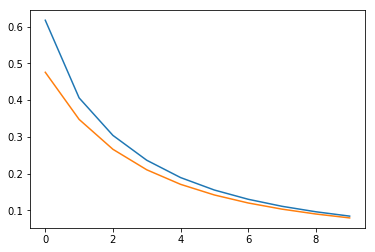

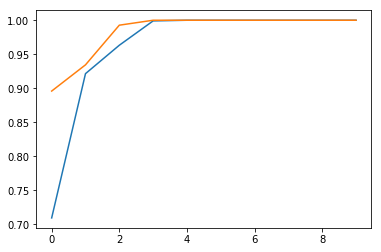

In [151]:
h = model.fit(x_train, y_train, epochs=10, batch_size=1024, validation_data=(x_test, y_test))

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()
plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

In [152]:
dist = 1
pos1 = np.zeros(18)
pos1[pos_2_1hot['DET']] = 1
pos2 = np.zeros(18)
pos2[pos_2_1hot['VERB']] = 1
model.predict(np.concatenate(([dist], pos1, pos2)).reshape(1, -1))

array([[0.8929501, 0.1006885]], dtype=float32)

In [153]:
dist = -1
pos1 = np.zeros(18)
pos1[pos_2_1hot['DET']] = 1
pos2 = np.zeros(18)
pos2[pos_2_1hot['VERB']] = 1
model.predict(np.concatenate(([dist], pos1, pos2)).reshape(1, -1))

array([[0.26844928, 0.7221041 ]], dtype=float32)

As we said, all the weights but the distances are near 0. This will predict (1, 0) if the distance is positive and (0, 1) if it's negative. Negative examples will never be well classed. We should add some so it can class them well. 

### Add negative examples